<a href="https://colab.research.google.com/github/Tatfi32/Image-Classifier/blob/master/Pre_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hijab/NON_Hijab Binary  Classification 

## Preliminary Set Up

### Google Disk connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path
path = Path("/content/drive/My Drive/")
dest = path/"hijab"
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
% cd '/content/drive/My Drive/hijab'

/content/drive/My Drive/hijab


### Cloning dataset from github rep (hijab/nonhijab images) 

In [ ]:
# ! git clone https://github.com/najcardboyz/naja-dataset.git

In [ ]:
! ls

keras_plot_model.png  model.png  naja-dataset  test_keras_plot_model.png


## Dataset preliminary preparation

### Processed images from directories

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train = ImageDataGenerator(validation_split=0.25, rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [ ]:
train_path = "/content/drive/My Drive/hijab/naja-dataset/dataset-2500/train/"
test_path = "/content/drive/My Drive/hijab/naja-dataset/dataset-2500/val/"

In [ ]:
train_dataset = train.flow_from_directory(train_path,
                                          target_size=(224,224),
                                          batch_size = 50,
                                          color_mode="rgb",
                                          class_mode = 'binary',
                                          shuffle=True,
                                          subset='training')

val_dataset = train.flow_from_directory(train_path,
                                        target_size=(224,224),
                                        batch_size = 50,
                                        color_mode="rgb",
                                        class_mode = 'binary',
                                        shuffle=True,
                                        subset='validation')
                                         
test_dataset = test.flow_from_directory(test_path,
                                        target_size=(224,224),
                                        batch_size = 50,
                                        color_mode="rgb",
                                        class_mode = 'binary',
                                        shuffle=False)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Dataset analysis

In [ ]:
test_dataset.class_indices

{'hijab': 0, 'nonhijab': 1}

In [ ]:
from matplotlib import pyplot as plt

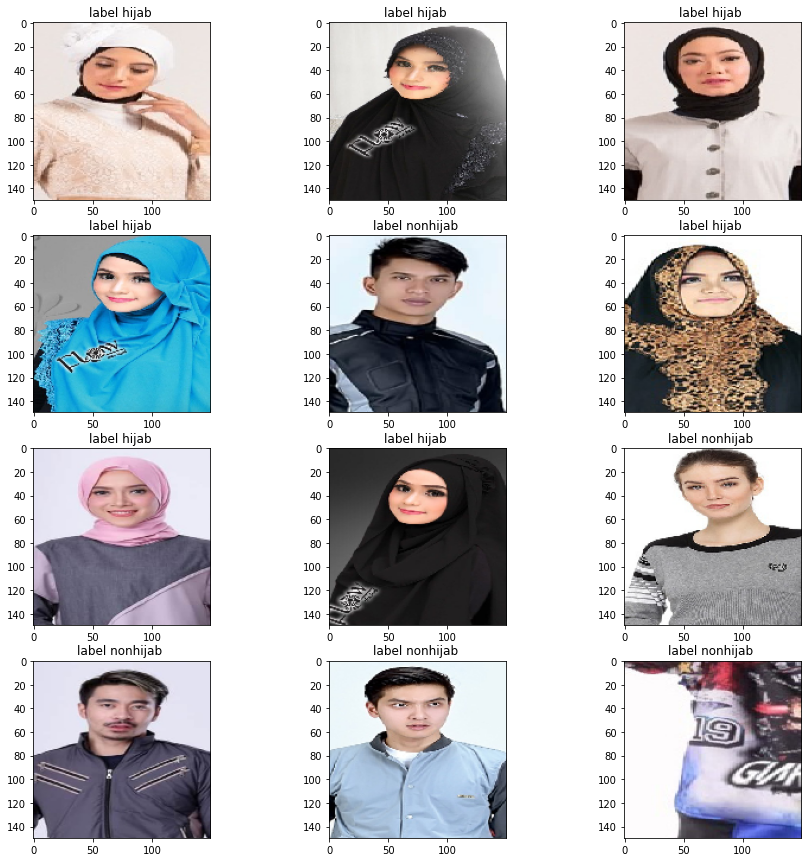

In [ ]:
plt.figure(figsize=(15,15))
x,y = train_dataset.next()[:12]
for i in range(0,12):
    plt.subplot(4, 3, i+1)
    plt.imshow(x[i])
    if (y[i]) == 1:  
        plt.title("label nonhijab ")
    else: 
         plt.title("label hijab ")
plt.show()

In [ ]:
labels = [train_dataset.labels, val_dataset.labels, test_dataset.labels]

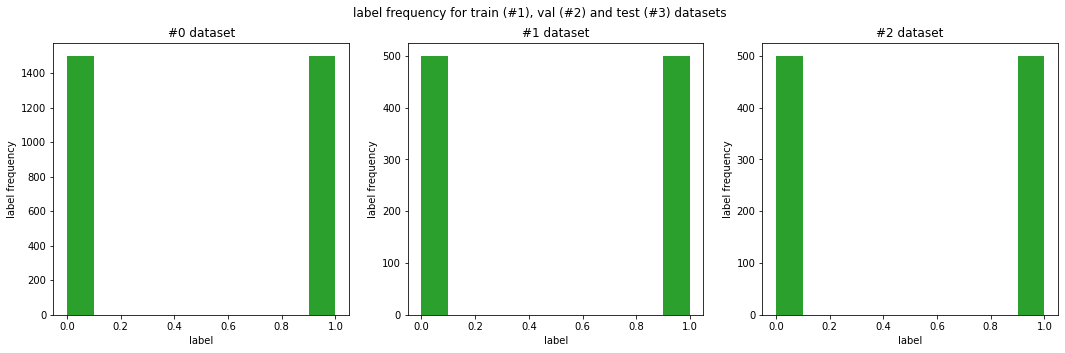

In [ ]:
fig =  plt.figure(figsize=(18,5))
for i in range(len(labels)):
    plt.subplot(1,3,i+1)
    plt.title("#%d dataset"%(i))
    img = labels[i]
    plt.hist(img,color='C2')
    plt.xlabel("label")
    plt.ylabel("label frequency")
fig.suptitle("label frequency for train (#1), val (#2) and test (#3) datasets")
fig.show()

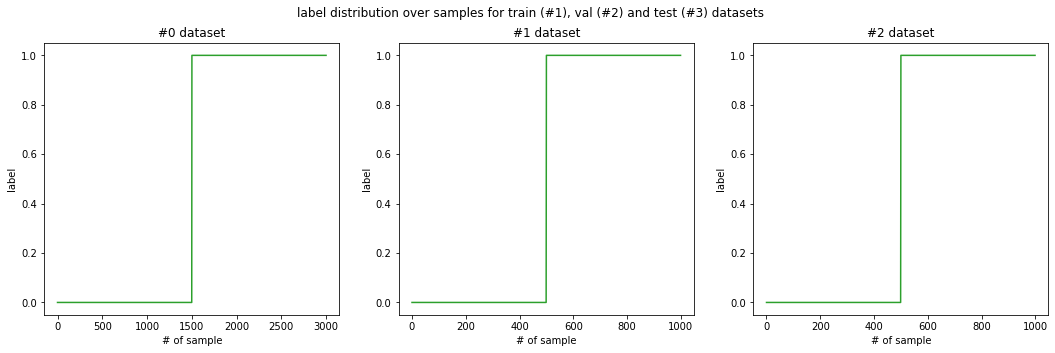

In [ ]:
fig = plt.figure(figsize=(18,5))
for i in range(len(labels)):
    plt.subplot(1,3,i+1)
    plt.title("#%d dataset"%(i))
    label_data = labels[i]
    plt.plot(range(0,len(label_data)),label_data, color='C2')
    plt.xlabel("# of sample")
    plt.ylabel("label")
fig.suptitle("label distribution over samples for train (#1), val (#2) and test (#3) datasets")
fig.show()

## Pre -trained CNN Model 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
import PIL.Image as Image
import numpy as np

### Prediction before tuning (An ImageNet classifier)
From https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub In our case, we will use the MobileNet V2 model developed at Google, and pre-trained on ImageNet, a large dataset of web images (1.4M images and 1000 classes). 

In [ ]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [ ]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,)) 
    ])

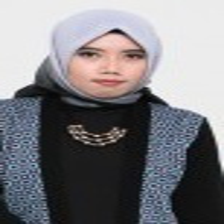

In [ ]:
image_path = test_dataset.filepaths[144]
img = Image.open(image_path).resize(IMAGE_SHAPE)
img

In [ ]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

400

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [ ]:
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name.title()

'Abaya'

### Tuning part (An ImageNet classifier)


From https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub In our case, we will use the MobileNet V2 model developed at Google, and pre-trained on ImageNet, a large dataset of web images (1.4M images and 1000 classes).

#### Display datatset prediction

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 224, 224, 3)
(50,)


In [ ]:
class_names = list(train_dataset.class_indices.keys())
class_names

['hijab', 'nonhijab']

In [ ]:
result_batch = classifier.predict(train_dataset)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['trench coat', 'abaya', 'ski mask', ..., 'abaya', 'bath towel',
       'shower cap'], dtype='<U30')

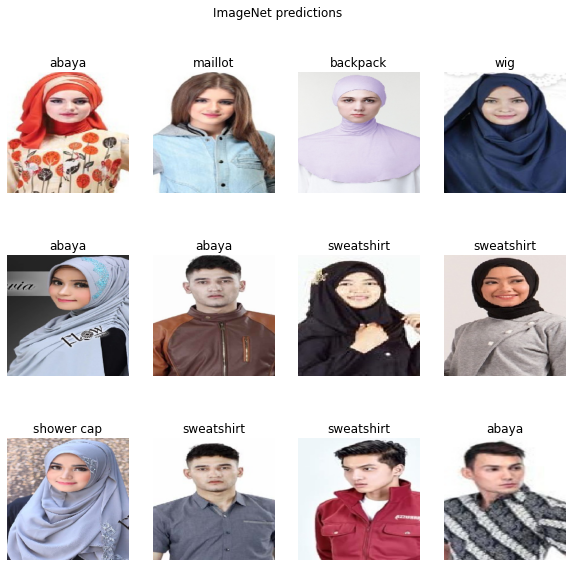

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(12):
  plt.subplot(3,4,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

#### Download the headless model

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(50, 1280)


#### Attach a classification head

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([50, 2])

#### Train the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [ ]:
history = model.fit(train_dataset, epochs=10,   callbacks=[batch_stats_callback])

Epoch 1/10
60/60 [==============================] - 491s 8s/step - loss: 0.2016 - acc: 0.9184
Epoch 2/10
60/60 [==============================] - 108s 2s/step - loss: 0.0583 - acc: 0.9846
Epoch 3/10
60/60 [==============================] - 107s 2s/step - loss: 0.0430 - acc: 0.9882
Epoch 4/10
60/60 [==============================] - 107s 2s/step - loss: 0.0344 - acc: 0.9918
Epoch 5/10
60/60 [==============================] - 107s 2s/step - loss: 0.0254 - acc: 0.9941
Epoch 6/10
60/60 [==============================] - 107s 2s/step - loss: 0.0213 - acc: 0.9967
Epoch 7/10
60/60 [==============================] - 106s 2s/step - loss: 0.0182 - acc: 0.9974
Epoch 8/10
60/60 [==============================] - 106s 2s/step - loss: 0.0156 - acc: 0.9974
Epoch 9/10
60/60 [==============================] - 106s 2s/step - loss: 0.0131 - acc: 0.9980
Epoch 10/10
60/60 [==============================] - 106s 2s/step - loss: 0.0116 - acc: 0.9987


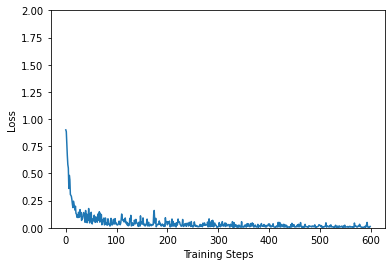

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

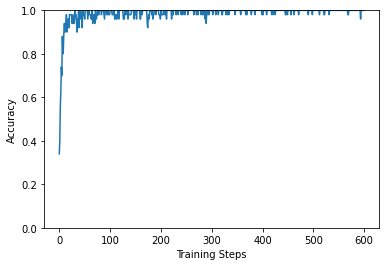

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = np.array(class_names)[predicted_id.astype(int)]

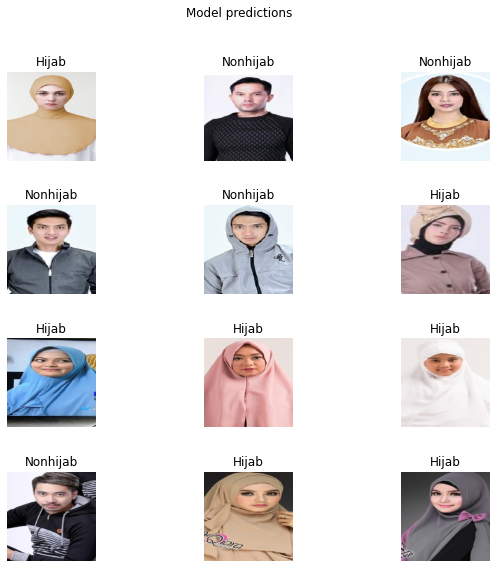

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(12):
  plt.subplot(4,3,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Saving the model

In [ ]:
import shutil
path = Path("/content/drive/My Drive/hijab")
dest = path/"saved_models"
if Path(dest).exists():
  shutil.rmtree(dest)
  dest.mkdir(parents=True, exist_ok=True)
else:
  dest.mkdir(parents=True, exist_ok=True)

In [ ]:
import time
t = time.time()

export_path = "/content/drive/My Drive/hijab/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /content/drive/My Drive/hijab/saved_models/1610710166/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/hijab/saved_models/1610710166/assets


'/content/drive/My Drive/hijab/saved_models/1610710166'

In [ ]:
for last_model_path in dest.iterdir(): 
  reloaded = tf.keras.models.load_model(last_model_path)


In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0